All rights reserved to https://pbcquoc.github.io/yolo/

## Import các thư viện
Thay vì khai báo các biến, định nghĩa các layer bằng tensorflow một cách chi tiết, chúng ta sử dụng high level api của trong gói slim để định gọi CNN một cách nhanh gọn hơn.

In [2]:
import tensorflow as tf
## slim là package đi kèm với tensorflow, giúp định nghĩa nhanh các loại mô hình deep learning
import tensorflow.contrib.slim as slim
import tensorflow.contrib.slim.nets
from tensorflow.contrib.slim.nets import vgg 
## sklearn là một thư viện rất phổ biến trong ML, chúng ta chỉ sử dụng tran_test_split để chia data thành 2 tập
from sklearn.model_selection import train_test_split
import json
## thư viện tính toán trên matrix
import numpy as np
import cv2
# thư viện hiển thị biểu đồ
import matplotlib.pyplot as plt
import time

In [0]:
# kích thước grid system 
cell_size = 7 
# số boundary box cần dự đoán mỗi ô vuông
box_per_cell = 2
# kích thước ảnh đầu vào
img_size = 224
# số loại nhãn
classes = {'circle':0, 'triangle':1,  'rectangle':2}
nclass = len(classes)

box_scale = 5.0
noobject_scale = 0.5
batch_size = 128
# số lần huấn luyện
# thử thay đổi số lần huấn luyện để cho kết quả tốt hơn
epochs = 10
# learning của chúng ta
lr = 2e-3

## Load tập dữ liệu
Chúng ta có 25k mẫu dữ liệu, mỗi ảnh có kích thước 224x224

In [3]:
def load():
    labels = json.load(open('train/labels.json'))
    # số lương ảnh
    N = len(labels)
    # matrix chứa ảnh
    X = np.zeros((N, img_size, img_size, 3), dtype='uint8')
    # matrix chứa nhãn của ảnh tương ứng
    y = np.zeros((N, cell_size, cell_size, 5+nclass))  # 5: (1, x_center, y_center, w, h), nclass = *cl
    for idx, label in enumerate(labels):
        # load labels, get idx and use cv2, find img and tranfer to px
        img = cv2.imread("train/{}.png".format(idx))
        X[idx] = img
        for box in label['boxes']:
            # 4 corner of boundary box
            x1, y1 = box['x1'], box['y1']
            x2, y2 = box['x2'], box['y2']
            # one-hot vector của nhãn object
            cl = [0]*nclass  #  = [0, 0, 0]
            cl[classes[box['class']]] = 1  # tranfer 1 to [0, 0 , 0] with index 0, 1, 2
            # tâm của boundary box
            x_center, y_center, w, h = (x1+x2)/2.0, (y1+y2)/2.0, x2-x1, y2-y1
            
            # TODO 
            # tìm ô vuông trên matrix 7x7 mà tâm object thuộc về
            x_idx, y_idx = int(x_center//(224/7)), int(y_center//(224/7))
            # print(x_idx, y_idx)
            # gán nhãn vào matrix 
            y[idx, y_idx, x_idx] = 1, x_center, y_center, w, h, *cl
    
    return X, y

### Download tập dữ liệu trên

In [ ]:
! wget --quiet --no-check-certificate 'https://drive.google.com/uc?export=download&id=1zt4Ek1907thRKeC3YcDIzFkYB2StIPy9' -O train.zip
! unzip -o -q train.zip
! ls train | head

In [0]:
X, y = load()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2018)

## Định nghĩa mô hình CNN
gridsize là 7x7 là mỗi ô vuông dự đoán 2 boxes, và có 3 loại object tất cả thì chúng ta phải cần output có shape 7x7x13 từ mô hình CNN.
YOLO sử dụng linear regression để dự đoán các thông tin ở mỗi ô vuông. Do đó, ở layer cuối cùng chúng ta sẽ không sử dụng bất kì hàm kích hoạt nào cả. Với ảnh đầu vào là 448x448, mô hình CNN có 6 tầng max pooling với size 2x2 sẽ giảm 64 lần kích thước ảnh xuống còn 7x7 ở output đầu ra. Đồng thời thay vì sử dụng tầng full connected ở các tầng cuối cùng, chúng ta có thể thay thế bằng tầng 1x1 conv với 13 feature maps để output shape dễ dàng cho ra 7x7x13.

In [0]:
def vgg16(inputs, is_training):
    """định nghĩa CNN
    Args:
      inputs: 5-D tensor [batch_size, width, height, 3]
    Return:
      iou: 4-D tensor [batch_size, 7, 7, 5*nbox + nclass]
    """
    # khái báo scope để có thê group những biến liên quan cho việc visualize trên tensorboard.
    with tf.variable_scope("vgg_16"):
        with slim.arg_scope(vgg.vgg_arg_scope()):
            # hàm repeat có tác dụng lặp lại tầng conv2d n lần mà không phải định nghĩa phức tạp. thank for slim package
            net = slim.repeat(inputs, 2, slim.conv2d, 16, [3, 3], scope='conv1')
            net = slim.max_pool2d(net, [2, 2], scope='pool1')
            
            # TODO
            # sử dụng slim.repeat  và slim.max_pool2d để định nghĩa phần còn lại của mô hình CNN
            # lưu ý kích thước matrix output phải là [batch_size, 7, 7, 5*nbox + nclass]
            # thay đổi số lượng tầng cũng như tham số để đạt kết quả iou trên tập valid > 0.92
            net = slim.repeat(net, 3, slim.conv2d, 32, [3, 3], scope='conv2')
            net = slim.max_pool2d(net, [2, 2], scope='pool2')
            net = slim.repeat(net, 3, slim.conv2d, 64, [3, 3], scope='conv3')
            net = slim.max_pool2d(net, [2, 2], scope='pool3')
            net = slim.repeat(net, 3, slim.conv2d, 128, [3, 3], scope='conv4')
            net = slim.max_pool2d(net, [2, 2], scope='pool4')
            net = slim.repeat(net, 3, slim.conv2d, 128, [3, 3], scope='conv5')
            net = slim.max_pool2d(net, [2, 2], scope='pool5')            
            # thay vì sử dụng 2 tầng fully connected tại đây, 
            # chúng ta sử dụng conv với kernel_size = (1,1) có tác dụng giống hệt tầng fully conntected
            net = slim.conv2d(net, 512, [1, 1], scope='fc6')   

            net = slim.conv2d(net, 13, [1, 1], activation_fn=None, scope='fc7')
    return net

## Hàm tính IOU 
là hàm rất quan trọng của mô hình YOLO, giúp chúng ta đánh giá các boundary box được dự đoán có chính xác hay không

In [0]:
def compute_iou(boxes1, boxes2, scope='iou'):
    """calculate ious
    Args:
      boxes1: 5-D tensor [BATCH_SIZE, CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 4]
                  ====> (x_center, y_center, w, h)
      boxes2: 5-D tensor [BATCH_SIZE, CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 4]
                  ====> (x_center, y_center, w, h)
    Return:
      iou: 4-D tensor [BATCH_SIZE, CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    """
    with tf.variable_scope(scope):
        # transform (x_center, y_center, w, h) to (x1, y1, x2, y2)
        boxes1_t = tf.stack([boxes1[..., 0] - boxes1[..., 2] / 2.0,
                             boxes1[..., 1] - boxes1[..., 3] / 2.0,
                             boxes1[..., 0] + boxes1[..., 2] / 2.0,
                             boxes1[..., 1] + boxes1[..., 3] / 2.0],
                            axis=-1)

        boxes2_t = tf.stack([boxes2[..., 0] - boxes2[..., 2] / 2.0,
                             boxes2[..., 1] - boxes2[..., 3] / 2.0,
                             boxes2[..., 0] + boxes2[..., 2] / 2.0,
                             boxes2[..., 1] + boxes2[..., 3] / 2.0],
                            axis=-1)

        # calculate the left up point & right down point
        lu = tf.maximum(boxes1_t[..., :2], boxes2_t[..., :2])
        rd = tf.minimum(boxes1_t[..., 2:], boxes2_t[..., 2:])

        # intersection
        intersection = tf.maximum(0.0, rd - lu)
        inter_square = intersection[..., 0] * intersection[..., 1]

        # calculate the boxs1 square and boxs2 square
        square1 = boxes1[..., 2] * boxes1[..., 3]
        square2 = boxes2[..., 2] * boxes2[..., 3]

        union_square = tf.maximum(square1 + square2 - inter_square, 1e-10)

    return tf.clip_by_value(inter_square / union_square, 0.0, 1.0)    

## Loss function

In [0]:
def loss_layer(predicts, labels, scope='loss_layer'):
    """calculate loss function
    Args:
      predicts: 4-D tensor [batch_size, 7, 7, 5*nbox+n_class] 
      labels: 4-D tensor [batch_size, 7, 7, 5+n_class]
    Return:
      loss: scalar
    """
    with tf.variable_scope(scope):
        offset = np.transpose(np.reshape(np.array(
            [np.arange(cell_size)] * cell_size * box_per_cell),
            (box_per_cell, cell_size, cell_size)), (1, 2, 0))
        offset = offset[None, :]
        offset = tf.constant(offset, dtype=tf.float32)
        offset_tran = tf.transpose(offset, (0, 2, 1, 3))

        #     offset_tran.shape = (1,7,7,2)
        
        # 2 phần tử đầu của vector dự đoán tại một ô vuông là confidence score
        predict_object = predicts[..., :box_per_cell]
        
        # 8 phần tử tiếp theo là dự đoán offset của boundary box và width height
        predict_box_offset = tf.reshape(
            predicts[..., box_per_cell:5 * box_per_cell],
            (-1, cell_size, cell_size, box_per_cell, 4)
        )
        
        # các phần tử cuối là dự đoán lớp của object
        predict_class = predicts[...,5*box_per_cell:]
        
        # chuyển vị trí offset về toạ độ normalize trên khoảng [0-1]
        predict_normalized_box = tf.stack(
            [(predict_box_offset[..., 0] + offset) / cell_size,
            (predict_box_offset[..., 1] + offset_tran) / cell_size,
            tf.square(predict_box_offset[..., 2]),
            tf.square(predict_box_offset[..., 3])], axis=-1)

        # lấy các nhãn tương ứng 
        true_object = labels[..., :1]
        true_box = tf.reshape(labels[..., 1:5], (-1, cell_size, cell_size, 1, 4))
        
        # để normalize tọa độ pixel về đoạn [0-1] chúng ta chia cho img_size (224)
        true_normalized_box = tf.tile(true_box, (1, 1, 1, box_per_cell, 1))/img_size
        true_class = labels[..., 5:]
        
        # tính vị trí offset từ nhãn 
        true_box_offset =  tf.stack(
            [true_normalized_box[..., 0] * cell_size - offset,
            true_normalized_box[..., 1] * cell_size - offset_tran,
            tf.sqrt(true_normalized_box[..., 2]),
            tf.sqrt(true_normalized_box[..., 3])], axis=-1)
        
        # tính iou
        predict_iou = compute_iou(true_normalized_box, predict_normalized_box)
        
        # mask chứa vị trí các ô vuông chứa object
        object_mask = tf.reduce_max(predict_iou, 3, keepdims=True)  
        
        # tính metric để monitor 
        iou_metric = tf.reduce_mean(
            tf.reduce_sum(object_mask, axis=[1,2,3])/
                tf.reduce_sum(true_object, axis=[1,2,3]))
        
        object_mask = tf.cast((predict_iou>=object_mask), tf.float32)*true_object

        noobject_mask = tf.ones_like(object_mask) - object_mask
        
        ## TODO tính classification loss
        ## class_delta là độ chênh lệch so với nhãn trước khi bình phương, 
        ## lưu ý chỉ object_mask để ignore những box không quan tâm
        class_delta = true_object * (predict_class - true_class)
        class_loss = tf.reduce_mean(
            tf.reduce_sum(tf.square(class_delta), axis=[1,2,3]), name='class_loss')
        
        ## object loss
        object_delta = object_mask*(predict_object - predict_iou)
        
        ## TODO tính object loss từ object_delta
        object_loss = tf.reduce_mean(tf.reduce_sum(tf.square(object_delta), axis=[1, 2, 3]), name='object_loss')
        
        ## TODO tính noobject loss
        noobject_delta = noobject_mask * predict_object
        noobject_loss = tf.reduce_mean(
            tf.reduce_sum(tf.square(noobject_delta),axis=[1,2,3]),
            name='noobject_loss') * noobject_scale

        ## TODO tính localization loss
        box_mask = tf.expand_dims(object_mask, 4)
        box_delta = box_mask * (predict_box_offset - true_box_offset)
        box_loss = tf.reduce_mean(
            tf.reduce_sum(tf.square(box_delta), axis=[1,2,3]), name='box_loss') * box_scale
        
        loss = 0.5*class_loss + object_loss + 0.1*noobject_loss + 10*box_loss
        
        return loss, iou_metric, predict_object, predict_class, predict_normalized_box

## Biên dịch graph
Phần khó đã qua, chúng mừng các bạn!!

Bây giờ là biên dịch graph và định nghĩa optimizer

In [0]:
graph = tf.Graph()
with graph.as_default():    
    # None đại diện cho batch_size, giúp batch_size có thể thay đổi linh hoạt
    images = tf.placeholder("float", [None, img_size, img_size, 3], name="input")
    labels = tf.placeholder('float', [None, cell_size, cell_size, 8], name='label')
    is_training = tf.placeholder(tf.bool)

    logits = vgg16(images, is_training)
    loss, iou_metric, predict_object, predict_class,\
        predict_normalized_box = loss_layer(logits, labels)
    
    # định nghĩa adam optimizer, để tối ưu hàm loss
    optimizer = tf.train.AdamOptimizer(lr)
    train_op = optimizer.minimize(loss)

## Training
Phần này chúng ta sẽ bắt đầu training, và tính iou metric để quan sát, iou nhận giá trị từ [0-1], sấp xỉ 1 là rất tốt

In [11]:
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    
    # định nghĩa saver để lưu lại trọng số của mô hình, dùng trong test các ảnh mới
    saver = tf.train.Saver(max_to_keep=1)

    for epoch in range(epochs):
        start_time = time.time()
        batch_time = []
        for batch in range(len(X_train)//batch_size):
            
            # TODO 
            # lấy từng batch, forward, backward, cập nhật trọng số theo adam optimizer
            
            X_batch = X_train[batch*batch_size:(batch+1)*batch_size, ...]
            y_batch = y_train[batch*batch_size:(batch+1)*batch_size, ...]
            train_total_loss, train_iou_m,_ = sess.run([loss, iou_metric, train_op], {images:X_batch, labels:y_batch, is_training:True})
        end_time = time.time()
        print('training time: {}'.format(end_time - start_time))
        # tính toán loss, iou trên tập validation
        val_loss = []
        val_iou_ms = []
        for batch in range(len(X_test)//batch_size):
            val_X_batch = X_test[batch*batch_size:(batch+1)*batch_size]
            val_y_batch = y_test[batch*batch_size:(batch+1)*batch_size]
            total_val_loss, val_iou_m, val_predict_object, val_predict_class, val_predict_normalized_box = sess.run([loss, iou_metric, predict_object, predict_class, predict_normalized_box], 
                                                 {images:val_X_batch, labels:val_y_batch, is_training:False})
            val_loss.append(total_val_loss)
            val_iou_ms.append(val_iou_m)
            
        epoch_time = time.time()
        saver.save(sess, './model/yolo', global_step=epoch)
        print('epoch: {} - test_time: {:.0f}s - train_loss: {:.3f} - train_iou: {:.3f} - val_loss: {:.3f} - val_iou: {:.3f}'.format(epoch, epoch_time - end_time, train_total_loss, train_iou_m, np.mean(val_loss), np.mean(val_iou_ms)))

training time: 92.21504545211792
epoch: 0 - test_time: 14s - train_loss: 2.999 - train_iou: 0.599 - val_loss: 3.082 - val_iou: 0.610
training time: 85.99295806884766
epoch: 1 - test_time: 14s - train_loss: 0.892 - train_iou: 0.695 - val_loss: 1.009 - val_iou: 0.724
training time: 85.95989894866943
epoch: 2 - test_time: 14s - train_loss: 0.746 - train_iou: 0.697 - val_loss: 0.632 - val_iou: 0.770
training time: 86.01082015037537
epoch: 3 - test_time: 14s - train_loss: 0.465 - train_iou: 0.794 - val_loss: 0.453 - val_iou: 0.783
training time: 86.025643825531
epoch: 4 - test_time: 14s - train_loss: 0.375 - train_iou: 0.826 - val_loss: 0.361 - val_iou: 0.809
training time: 86.01230359077454
epoch: 5 - test_time: 14s - train_loss: 0.329 - train_iou: 0.830 - val_loss: 0.343 - val_iou: 0.788
training time: 86.0119309425354
epoch: 6 - test_time: 14s - train_loss: 0.271 - train_iou: 0.841 - val_loss: 0.296 - val_iou: 0.830
training time: 86.01074004173279
epoch: 7 - test_time: 14s - train_loss:

## Hiển thị kết quả dự đoán
Filter tất cả các box không thỏa điều kiện như ko chứa object, merge các box overlap nhiều

In [0]:
def iou(box1, box2):
    """ tính iou bằng numpy 
    Args:
      box1: [center_x, center_y, w, h] 
      box2: [center_x, center_y, w, h] 
    Return:
      iou: iou
    """
    tb = min(box1[0] + 0.5 * box1[2], box2[0] + 0.5 * box2[2]) - \
        max(box1[0] - 0.5 * box1[2], box2[0] - 0.5 * box2[2])
    lr = min(box1[1] + 0.5 * box1[3], box2[1] + 0.5 * box2[3]) - \
        max(box1[1] - 0.5 * box1[3], box2[1] - 0.5 * box2[3])
    inter = 0 if tb < 0 or lr < 0 else tb * lr
    return inter / (box1[2] * box1[3] + box2[2] * box2[3] - inter)
    
def interpret_output(predict_object, predict_class, predict_normalized_box):
    # nhận lại img-size để ra không gian pixel
    predict_box= predict_normalized_box*img_size
    predict_object = np.expand_dims(predict_object, axis=-1)
    predict_class = np.expand_dims(predict_class, axis=-2)
    # xác suất ô boundary chứa class bằng boundary chứa object * xác suất có điều kiện của lớp đó mà ô vuông chứa object
    class_probs = predict_object*predict_class
    
    # giữ các boundary box mà có xác suất chứa lớp >= 0.2
    filter_mat_probs = np.array(class_probs >= 0.2, dtype='bool')
    filter_mat_boxes = np.nonzero(filter_mat_probs)
    boxes_filtered = predict_box[filter_mat_boxes[0], filter_mat_boxes[1], filter_mat_boxes[2]]
    class_probs_filtered = class_probs[filter_mat_probs]
    
    # chọn index của lớp có xác xuất lớp nhất lại mỗi boundary box
    classes_num_filtered = np.argmax(
        filter_mat_probs, axis=3)[
        filter_mat_boxes[0], filter_mat_boxes[1], filter_mat_boxes[2]]

    # giữ lại boundary box dự đoán có xác xuất lớp nhất
    argsort = np.array(np.argsort(class_probs_filtered))[::-1]
    boxes_filtered = boxes_filtered[argsort]
    class_probs_filtered = class_probs_filtered[argsort]
    classes_num_filtered = classes_num_filtered[argsort]

    # thuật toán non-maximun suppression
    for i in range(len(boxes_filtered)):
        if class_probs_filtered[i] == 0:
            continue
        for j in range(i + 1, len(boxes_filtered)):
            if iou(boxes_filtered[i], boxes_filtered[j]) > 0.5:
                class_probs_filtered[j] = 0.0
                
    # filter bước cuối bỏ những boundary overlap theo thuật toán trên
    filter_iou = np.array(class_probs_filtered > 0.0, dtype='bool')
    boxes_filtered = boxes_filtered[filter_iou]
    class_probs_filtered = class_probs_filtered[filter_iou]
    classes_num_filtered = classes_num_filtered[filter_iou]

    result = []
    for i in range(len(boxes_filtered)):
        result.append(
            [classes_num_filtered[i],
             boxes_filtered[i][0],
             boxes_filtered[i][1],
             boxes_filtered[i][2],
             boxes_filtered[i][3],
             class_probs_filtered[i]])

    return result

def draw_result(img, result):
    """ hiển thị kết quả dự đoán
    Args:
      img: ảnh      
      result: giá trị sinh ra ở hàm trên    
    """
    plt.figure(figsize=(10,10), dpi=40)
    img = np.pad(img, [(50,50), (50,50), (0,0)], mode='constant', constant_values=255)
    for i in range(len(result)):
        x = int(result[i][1])+50
        y = int(result[i][2])+50
        w = int(result[i][3] / 2)
        h = int(result[i][4] / 2)
        cv2.rectangle(img, (x - w, y - h), (x + w, y + h), (231, 76, 60), 2)
        cv2.rectangle(img, (x - w, y - h - 20),
                      (x -w + 50, y - h), (46, 204, 113), -1)
        cv2.putText(
            img, '{} : {:.2f}'.format(result[i][0] ,result[i][5]),
            (x - w + 5, y - h - 7), cv2.FONT_HERSHEY_SIMPLEX, 0.3,
            (0, 0, 0), 1, cv2.LINE_AA)

    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

Chọn một từ tập validation, rồi hiển thị 

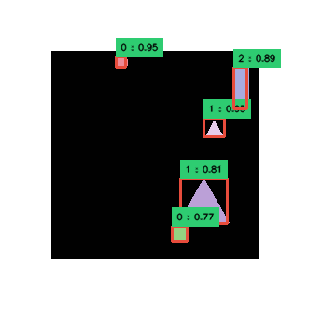

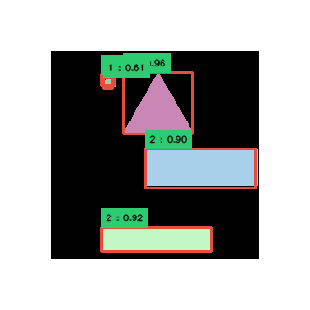

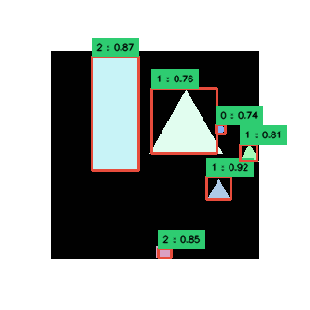

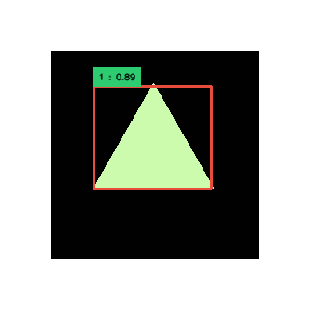

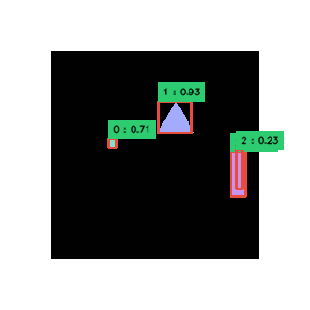

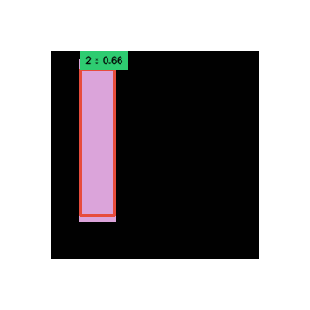

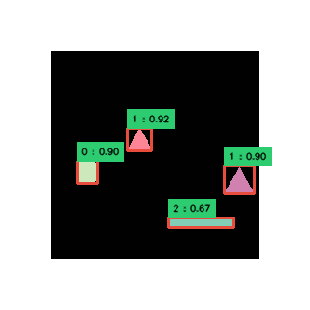

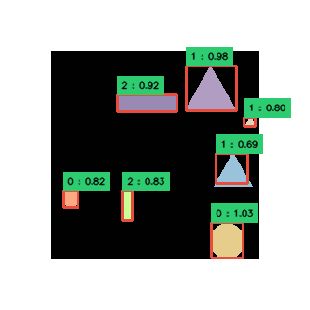

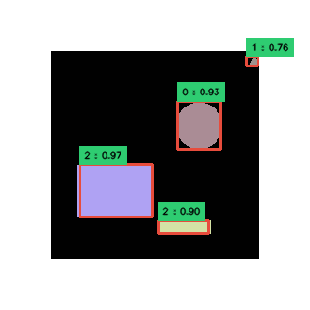

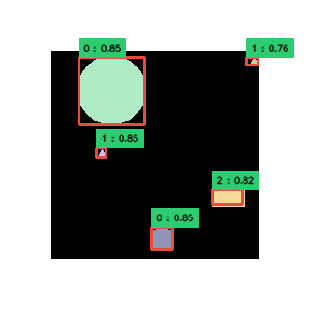

In [17]:
for img_idx in range(10):
    result = interpret_output(val_predict_object[img_idx], val_predict_class[img_idx], val_predict_normalized_box[img_idx])
    draw_result(val_X_batch[img_idx]*255, result)            